# Imports

In [317]:
import os
import getpass
import geopandas as gpd
import pandas as pd
import ipyleaflet
import ipywidgets
import math
import datetime
import json
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib


from IPython.display import display, HTML

# Database Connection

In [13]:
dbpass = getpass.getpass()

········


In [376]:
# Connect to database
print('Connecting ..')
conn = psycopg2.connect(
    host='humanplusdb.vomatec.de',
    database='HUMAN',
    port=5222,
    user='forschungspartner',
    password=dbpass
)
print('Connected')

Connecting ..
Connected


# Foo

In [2]:
# https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
shapefile_nuts0 = 'data/NUTS_RG_01M_2016_4326_LEVL_0.shp/NUTS_RG_01M_2016_4326_LEVL_0.shp'
shapefile_nuts1 = 'data/NUTS_RG_01M_2016_4326_LEVL_1.shp/NUTS_RG_01M_2016_4326_LEVL_1.shp'
shapefile_nuts2 = 'data/NUTS_RG_01M_2016_4326_LEVL_2.shp/NUTS_RG_01M_2016_4326_LEVL_2.shp'
shapefile_nuts3 = 'data/NUTS_RG_01M_2016_4326_LEVL_3.shp/NUTS_RG_01M_2016_4326_LEVL_3.shp'
SRID = 4326

# Resolve countries into shapes
nuts0_shapes = gpd.read_file(shapefile_nuts0)
nuts1_shapes = gpd.read_file(shapefile_nuts1)
nuts2_shapes = gpd.read_file(shapefile_nuts2)
nuts3_shapes = gpd.read_file(shapefile_nuts3)

In [397]:
nuts_shapes_by_level = {}
def get_nuts_shapes(nuts_level : int, data_dir='data/'):
    if nuts_level not in nuts_shapes_by_level:
        shapefile_name = 'NUTS_RG_01M_2016_4326_LEVL_%s.shp/NUTS_RG_01M_2016_4326_LEVL_%s.shp' % (nuts_level, nuts_level)
        shapefile_path = os.path.join(data_dir, shapefile_name)
        nuts_shapes_by_level[nuts_level] = gpd.read_file(shapefile_path)
    return nuts_shapes_by_level[nuts_level]

In [399]:
get_nuts_shapes(0)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry
0,0,AL,AL,SHQIPÃRIA,AL,"(POLYGON ((19.831 42.46645, 19.83568 42.47103,..."
1,0,CZ,CZ,ÄESKÃ REPUBLIKA,CZ,"POLYGON ((14.49122 51.04353, 14.49945 51.0461,..."
2,0,DE,DE,DEUTSCHLAND,DE,"(POLYGON ((10.45444 47.5558, 10.43954 47.52466..."
3,0,DK,DK,DANMARK,DK,"(POLYGON ((10.19436 56.68466, 10.20395 56.6825..."
4,0,CY,CY,ÎÎ¥Î Î¡ÎÎ£,CY,"(POLYGON ((34.58451 35.69436, 34.57359 35.6680..."
5,0,AT,AT,ÃSTERREICH,AT,"(POLYGON ((10.45444 47.5558, 10.4732 47.55036,..."
6,0,BE,BE,BELGIQUE-BELGIÃ,BE,"(POLYGON ((5.10218 51.429, 5.07105 51.39342, 5..."
7,0,BG,BG,ÐÐªÐÐÐÐ ÐÐ¯,BG,"POLYGON ((22.67516 44.21566, 22.69084 44.20456..."
8,0,CH,CH,SCHWEIZ/SUISSE/SVIZZERA,CH,"POLYGON ((8.61383 47.80108, 8.621549999999999 ..."
9,0,EE,EE,EESTI,EE,"(POLYGON ((25.83016 59.56406, 25.84849 59.5698..."


In [3]:
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

In [4]:
nuts0_shapes.columns

Index(['LEVL_CODE', 'NUTS_ID', 'CNTR_CODE', 'NUTS_NAME', 'FID', 'geometry'], dtype='object')

In [5]:
#cols = ['street_address', 'issue_type', 'status']
#geojson = df_to_geojson(nuts0_shapes, cols)

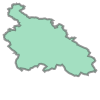

In [8]:
nuts1_shapes[nuts1_shapes['NUTS_ID'] == 'HU1']['geometry'].values[0]

In [9]:
m.add_layer(nuts1_shapes[nuts1_shapes['NUTS_ID'] == 'HU1']['geometry'].values[0])

AttributeError: 'Polygon' object has no attribute 'model_id'

In [56]:
nuts1_shapes

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry
0,1,BE3,BE,RÃGION WALLONNE,BE3,"(POLYGON ((5.682 50.75745, 5.68973 50.75158, 5..."
1,1,CH0,CH,SCHWEIZ/SUISSE/SVIZZERA,CH0,"POLYGON ((8.61383 47.80108, 8.621549999999999 ..."
2,1,DE1,DE,BADEN-WÃRTTEMBERG,DE1,"(POLYGON ((10.08372 49.54356, 10.08747 49.5375..."
3,1,CY0,CY,ÎÎ¥Î Î¡ÎÎ£,CY0,"(POLYGON ((34.58451 35.69436, 34.57359 35.6680..."
4,1,DEA,DE,NORDRHEIN-WESTFALEN,DEA,"POLYGON ((8.703010000000001 52.50044, 8.699059..."
...,...,...,...,...,...,...
120,1,TR3,TR,EGE,TR3,"(POLYGON ((29.74218 39.87133, 29.73424 39.8398..."
121,1,TRA,TR,KUZEYDOGU ANADOLU,TRA,"POLYGON ((43.46964 41.05734, 43.48579 41.02216..."
122,1,TR9,TR,DOGU KARADENIZ,TR9,"POLYGON ((42.51518 41.43828, 42.52662 41.40842..."
123,1,TR5,TR,BATI ANADOLU,TR5,"POLYGON ((32.55482 40.69194, 32.59134 40.68434..."


In [130]:
def get_geodata_in_box(conn, nuts_code_level : int, southwest_lat : float, southwest_lon : float, northeast_lat : float, northeast_lon : float):
    bounding_box = 'ST_MakeEnvelope(%s, %s, %s, %s, 4326)' % (southwest_lon, southwest_lat, northeast_lon, northeast_lat)

    # Select all nuts codes and geometry within the bounding box from database
    sql_nuts_geometries = 'select nuts_code, geometry from nuts_shapes where nuts_code_level = %s and ST_Intersects(geometry, %s);'
    execute_sql = sql_nuts_geometries % (nuts_code_level, bounding_box)
    #print(execute_sql)
    return gpd.GeoDataFrame.from_postgis(execute_sql, conn, geom_col='geometry')

In [131]:
cur_data = get_geodata_in_box(conn, 1, 47.59134647679713, 5.47119140625, 50.47149085139956, 15.996093750000002)

In [81]:
cur_data

,nuts_code,geometry
0,AT2,"POLYGON ((15.84791 47.56847, 15.86376 47.56696..."
1,BE3,"(POLYGON ((5.682 50.75745, 5.68973 50.75158, 5..."
2,CH0,"POLYGON ((8.61383 47.80108, 8.621549999999999 ..."
3,DE1,"(POLYGON ((10.08372 49.54356, 10.08747 49.5375..."
4,DEA,"POLYGON ((8.703010000000001 52.50044, 8.699059..."
5,DE7,"(POLYGON ((9.68533 51.58202, 9.690189999999999..."
6,DEB,"POLYGON ((7.8515 50.92583, 7.83388 50.90767, 7..."
7,DEC,"POLYGON ((7.27662 49.54862, 7.27738 49.53778, ..."
8,DED,"(POLYGON ((13.05103 51.64768, 13.07605 51.6223..."
9,DEG,"POLYGON ((10.91606 51.61637, 10.91925 51.61578..."


In [177]:
def get_aggregated_observations(conn, nuts_codes, date_begin, date_end, fn_agg='sum'):
    if fn_agg not in ('sum', 'avg', 'min', 'max'):
        raise ValueError('Unknown sql aggregation function "%s"' % agg)
        
    nuts_codes_list = '\'' + '\', \''.join(nuts_codes) + '\''
    sql_select = 'select nuts_code, %s(no_persons) from forecast where nuts_code in (%s) and valid_from between \'%s\' and \'%s\' group by nuts_code'
    sql_select_execute = sql_select % (fn_agg, nuts_codes_list, date_begin, date_end)
    #print(sql_select_execute)
    cursor = conn.cursor()
    cursor.execute(sql_select_execute)
    result = cursor.fetchall()
    cursor.close()
    return {res[0]: res[1] for res in result}

In [178]:
no_persons = get_aggregated_observations(conn, nuts2_shapes['NUTS_ID'].values, '2019-09-26', '2019-10-02')

In [179]:
nuts2_shapes_copy = gpd.GeoDataFrame(nuts2_shapes)

In [180]:
nuts2_shapes_copy['Persons'] = [no_persons[code] if code in no_persons else 0 for code in nuts2_shapes['NUTS_ID'].values]


In [183]:
nuts2_shapes_copy[nuts2_shapes_copy['Persons'] != 0]

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Persons
5,2,DE13,DE,Freiburg,DE13,"(POLYGON ((8.222009999999999 48.60323, 8.21404...",2024
7,2,AT32,AT,Salzburg,AT32,"POLYGON ((13.30382 48.00782, 13.30366 48.004, ...",2417
12,2,AT11,AT,Burgenland,AT11,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ...",3
14,2,AT33,AT,Tirol,AT33,"(POLYGON ((10.45444 47.5558, 10.4732 47.55036,...",2923
15,2,DE14,DE,TÃ¼bingen,DE14,"POLYGON ((10.23078 48.51051, 10.23266 48.50851...",3738
16,2,AT34,AT,Vorarlberg,AT34,"POLYGON ((9.96781 47.54624, 9.97038 47.54455, ...",1730
21,2,DE21,DE,Oberbayern,DE21,"(POLYGON ((11.59931 48.9515, 11.62117 48.94391...",3707
24,2,AT22,AT,Steiermark,AT22,"POLYGON ((15.84791 47.56847, 15.86376 47.56696...",1058
31,2,AT12,AT,NiederÃ¶sterreich,AT12,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,...",1374
32,2,AT13,AT,Wien,AT13,"POLYGON ((16.18577 48.1724, 16.20238 48.18904,...",4


In [198]:
def get_observations(conn, nuts_codes, date_begin, date_end):
    nuts_codes_list = '\'' + '\', \''.join(nuts_codes) + '\''
    sql_select = 'select f.nuts_code, f.valid_from, s.nuts_name, f.no_persons, s.geometry from nuts_shapes as s, forecast as f where f.nuts_code = s.nuts_code and s.nuts_code in (%s) and f.valid_from between \'%s\' and \'%s\' order by f.nuts_code, f.valid_from'
    sql_select_execute = sql_select % (nuts_codes_list, date_begin, date_end)
    #print(sql_select_execute)
    return gpd.GeoDataFrame.from_postgis(sql_select_execute, conn, geom_col='geometry')

In [210]:
timeseries_data = get_observations(conn, nuts2_shapes['NUTS_ID'].values, '2019-09-26', '2019-10-02')
# We need to stringify the timestamped column, otherwise serialization gives problems with ipyleaflet
timeseries_data['valid_from'] = timeseries_data['valid_from'].dt.strftime('%Y-%m-%d')
timeseries_data

,nuts_code,valid_from,nuts_name,no_persons,geometry
0,AT11,2019-09-29,Burgenland,1,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ..."
1,AT11,2019-09-30,Burgenland,1,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ..."
2,AT11,2019-10-01,Burgenland,1,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ..."
3,AT11,2019-10-02,Burgenland,0,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ..."
4,AT12,2019-09-29,Niederösterreich,543,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,..."
5,AT12,2019-09-30,Niederösterreich,421,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,..."
6,AT12,2019-10-01,Niederösterreich,260,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,..."
7,AT12,2019-10-02,Niederösterreich,150,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,..."
8,AT13,2019-09-29,Wien,1,"POLYGON ((16.18577 48.1724, 16.20238 48.18904,..."
9,AT13,2019-09-30,Wien,1,"POLYGON ((16.18577 48.1724, 16.20238 48.18904,..."


In [218]:
timed_agg_data = get_aggregated_observations(conn, nuts2_shapes['NUTS_ID'].values, '2019-09-26', '2019-10-02')
timed_data = gpd.GeoDataFrame(nuts2_shapes)
timed_data['Persons'] = [timed_agg_data[code] if code in timed_agg_data else 0 for code in timed_data['NUTS_ID'].values]

timed_data
timed_data[timed_data['Persons'] != 0]

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Persons
5,2,DE13,DE,Freiburg,DE13,"(POLYGON ((8.222009999999999 48.60323, 8.21404...",2024
7,2,AT32,AT,Salzburg,AT32,"POLYGON ((13.30382 48.00782, 13.30366 48.004, ...",2417
12,2,AT11,AT,Burgenland,AT11,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ...",3
14,2,AT33,AT,Tirol,AT33,"(POLYGON ((10.45444 47.5558, 10.4732 47.55036,...",2923
15,2,DE14,DE,TÃ¼bingen,DE14,"POLYGON ((10.23078 48.51051, 10.23266 48.50851...",3738
16,2,AT34,AT,Vorarlberg,AT34,"POLYGON ((9.96781 47.54624, 9.97038 47.54455, ...",1730
21,2,DE21,DE,Oberbayern,DE21,"(POLYGON ((11.59931 48.9515, 11.62117 48.94391...",3707
24,2,AT22,AT,Steiermark,AT22,"POLYGON ((15.84791 47.56847, 15.86376 47.56696...",1058
31,2,AT12,AT,NiederÃ¶sterreich,AT12,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,...",1374
32,2,AT13,AT,Wien,AT13,"POLYGON ((16.18577 48.1724, 16.20238 48.18904,...",4


In [220]:
timed_data_observed_persons = dict(zip(timed_data['NUTS_ID'], timed_data['Persons']))
timed_data_observed_persons

{'CH02': 0,
 'CH03': 0,
 'AL02': 0,
 'AL03': 0,
 'BG33': 0,
 'DE13': 2024,
 'CZ05': 0,
 'AT32': 2417,
 'CH04': 0,
 'CH05': 0,
 'ES53': 0,
 'BG34': 0,
 'AT11': 3,
 'BG41': 0,
 'AT33': 2923,
 'DE14': 3738,
 'AT34': 1730,
 'BE10': 0,
 'BE21': 0,
 'BG42': 0,
 'CZ08': 0,
 'DE21': 3707,
 'CH06': 0,
 'CZ02': 0,
 'AT22': 1058,
 'BG32': 0,
 'CH01': 0,
 'BE24': 0,
 'BE25': 0,
 'CZ06': 0,
 'CH07': 0,
 'AT12': 1374,
 'AT13': 4,
 'AT21': 2529,
 'BE31': 0,
 'BE32': 0,
 'CZ03': 0,
 'CY00': 0,
 'CZ01': 0,
 'BE22': 0,
 'BE23': 0,
 'BE33': 0,
 'CZ07': 0,
 'ES12': 0,
 'BE34': 0,
 'DE11': 6082,
 'DE22': 5536,
 'BE35': 0,
 'CZ04': 0,
 'ES24': 0,
 'ES30': 0,
 'BG31': 0,
 'DE12': 4848,
 'AL01': 0,
 'AT31': 3117,
 'DE73': 0,
 'DK04': 0,
 'DE40': 0,
 'DE93': 0,
 'ITH3': 0,
 'EL41': 0,
 'EL42': 0,
 'EL65': 0,
 'DEB1': 0,
 'EE00': 0,
 'DE94': 0,
 'DEB2': 0,
 'DE80': 0,
 'DEA3': 0,
 'DK03': 0,
 'DE24': 0,
 'DE27': 0,
 'DE71': 0,
 'EL61': 0,
 'DE91': 0,
 'ITG1': 0,
 'EL64': 0,
 'DEA4': 0,
 'EL30': 0,
 'EL43': 0,
 

In [402]:
def get_aggregated_observations_with_shapes(conn, nuts_codes, date_begin, date_end, fn_agg='sum'):
    if fn_agg not in ('sum', 'avg', 'min', 'max'):
        raise ValueError('Unknown sql aggregation function "%s"' % agg)
        
    nuts_codes_list = '\'' + '\', \''.join(nuts_codes) + '\''
    sql_select = 'select f.nuts_code, s.nuts_name, %s(f.no_persons) as no_persons, s.geometry from nuts_shapes as s, forecast as f where f.nuts_code = s.nuts_code and s.nuts_code in (%s) and valid_from between \'%s\' and \'%s\' group by f.nuts_code, s.nuts_name, s.geometry'
    sql_select_execute = sql_select % (fn_agg, nuts_codes_list, date_begin, date_end)
    #print(sql_select_execute)
    return gpd.GeoDataFrame.from_postgis(sql_select_execute, conn, geom_col='geometry')

In [389]:
get_aggregated_observations_with_shapes(conn, nuts2_shapes['NUTS_ID'].values, '2019-09-26', '2019-10-02')

,nuts_code,nuts_name,sum,geometry
0,AT11,Burgenland,3,"POLYGON ((17.1608 48.00666, 17.13656 47.9951, ..."
1,AT12,Niederösterreich,1374,"POLYGON ((15.54245 48.9077, 15.54903 48.90622,..."
2,AT13,Wien,4,"POLYGON ((16.18577 48.1724, 16.20238 48.18904,..."
3,AT21,Kärnten,2529,"POLYGON ((13.35458 47.0973, 13.3632 47.09821, ..."
4,AT22,Steiermark,1058,"POLYGON ((15.84791 47.56847, 15.86376 47.56696..."
5,AT31,Oberösterreich,3117,"POLYGON ((14.69101 48.5843, 14.69236 48.58081,..."
6,AT32,Salzburg,2417,"POLYGON ((13.30382 48.00782, 13.30366 48.004, ..."
7,AT33,Tirol,2923,"(POLYGON ((10.45444 47.5558, 10.4732 47.55036,..."
8,AT34,Vorarlberg,1730,"POLYGON ((9.96781 47.54624, 9.97038 47.54455, ..."
9,DE11,Stuttgart,6082,"(POLYGON ((10.08372 49.54356, 10.08747 49.5375..."


In [390]:
get_aggregated_observations_with_shapes(conn, nuts0_shapes['NUTS_ID'].values, '2019-09-26', '2019-10-02')

,nuts_code,nuts_name,sum,geometry
0,AT,ÖSTERREICH,53646,"(POLYGON ((10.45444 47.5558, 10.4732 47.55036,..."
1,EL,ΕΛΛΑΔΑ,34102,"(POLYGON ((26.35788 41.7111, 26.36917 41.70811..."
2,HR,HRVATSKA,51021,"(POLYGON ((16.59681 46.4759, 16.59863 46.47723..."
3,HU,MAGYARORSZÁG,1211,"(POLYGON ((22.12108 48.37831, 22.12632 48.3805..."
4,IT,ITALIA,374,"(POLYGON ((12.24075 47.06917, 12.23652 47.0654..."
5,MK,North Macedonia,56696,"POLYGON ((22.36021 42.31116, 22.36704 42.30863..."
6,RS,REPUBLIKA SRBIJA /РЕПУБЛИКА СРБИЈА,58954,"(POLYGON ((19.6981 46.18793, 19.71528 46.17716..."
7,SI,SLOVENIJA,54174,"(POLYGON ((16.37079 46.72224, 16.37931 46.7124..."


# Display IPyLeaflet Map

In [201]:
class DateRangePicker(object):
    def __init__(self,start,end,freq='D',fmt='%Y-%m-%d'):
        """
        Parameters
        ----------
        start : string or datetime-like
            Left bound of the period
        end : string or datetime-like
            Left bound of the period
        freq : string or pandas.DateOffset, default='D'
            Frequency strings can have multiples, e.g. '5H' 
        fmt : string, defauly = '%Y-%m-%d'
            Format to use to display the selected period

        """
        self.date_range=pd.date_range(start=start,end=end,freq=freq)
        options = [(item.strftime(fmt),item) for item in self.date_range]
        self.slider_start = widgets.SelectionSlider(
            description='start',
            options=options,
            continuous_update=False
        )
        self.slider_end = widgets.SelectionSlider(
            description='end',
            options=options,
            continuous_update=False,
            value=options[-1][1]
        )

        self.slider_start.on_trait_change(self.slider_start_changed, 'value')
        self.slider_end.on_trait_change(self.slider_end_changed, 'value')

        self.widget = widgets.Box(children=[self.slider_start,self.slider_end])

    def slider_start_changed(self,key,value):
        self.slider_end.value=max(self.slider_start.value,self.slider_end.value)
        self._observe(start=self.slider_start.value,end=self.slider_end.value)

    def slider_end_changed(self,key,value):
        self.slider_start.value=min(self.slider_start.value,self.slider_end.value)
        self._observe(start=self.slider_start.value,end=self.slider_end.value)

    def display(self):
        display(self.slider_start,self.slider_end)

    def _observe(self,**kwargs):
        if hasattr(self,'observe'):
            self.observe(**kwargs)

In [60]:
def zoom2nuts(zoom_level : int):
    """
    Given a map zoom level resolve a nuts code level for display.
    """
    return 3 if zoom_level >= 7 else 2 if zoom_level >= 6 else 1

In [47]:
def update_html(feature,  **kwargs):
    html.value = '''
        <h3><b>{}</b></h3>
        <h4>NUTS_ID: {}</h4>
    '''.format(feature['properties']['NUTS_NAME'],
               feature['properties']['NUTS_ID'])

In [227]:
def to_choropleth(df: gpd.GeoDataFrame, choro_column, geometry_column = 'geometry'):
    def to_geojson(vals: gpd.GeoSeries):
        return eval(vals.to_json())
    
    return ipyleaflet.Choropleth(
        geo_data = to_geojson(df[geometry_column]),
        choro_data = to_geojson(df[choro_column]),
        colormap=ipyleaflet.linear.YlOrRd_04,
        border_color='gray',
        style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
    )

In [411]:
def merge_df(data, nuts_shapes, nuts_ids_column, color_column):
    agg_data = data.groupby(nuts_ids_column).sum()
    merged_df = pd.merge(agg_data, nuts_shapes, left_on = nuts_ids_column, right_on = 'NUTS_ID')
    return merged_df.dropna(subset = ['NUTS_ID', color_column])

In [251]:
def get_time_slider(df, timestamp_column = 'valid_from'):
    def get_date_range():
        timestamps = pd.to_datetime(df[timestamp_column]).apply(pd.Timestamp.date)
        vmin, vmax = timestamps.min(), timestamps.max()
        return pd.Series(pd.date_range(vmin, vmax)).apply(pd.Timestamp.date)

    date_range = get_date_range()
    return ipywidgets.SelectionRangeSlider(
        options = date_range.values,
        description = 'Date Range',
        continuous_update=False,
        index = (0, len(date_range)-1),
        values=(0, len(date_range)),
        layout = ipywidgets.Layout(width = '500px')
    )

In [351]:
def get_time_slider_from_db(conn):
    sql_select_range = 'select min(valid_from), max(valid_from) from forecast'
    #print(sql_select_execute)
    cursor = conn.cursor()
    cursor.execute(sql_select_range)
    date_range = cursor.fetchone()
    cursor.close()
    
    #date_range = pd.date_range(start=date_range[0], end=date_range[1], freq='d')
    date_range = pd.Series(pd.date_range(date_range[0], date_range[1])).apply(pd.Timestamp.date)
    
    return ipywidgets.SelectionRangeSlider(
        options = date_range.values,
        description = 'Date Range',
        continuous_update=False,
        index = (0, len(date_range)-1),
        values=(0, len(date_range)),
        layout = ipywidgets.Layout(width = '500px')
    )

In [403]:
test_slider = get_time_slider_from_db(conn)
nuts_code_level = ipywidgets.Dropdown(options = [0, 1, 2], description = 'NUTS Level', layout = ipywidgets.Layout(width = '20%'))
ui = ipywidgets.HBox([nuts_code_level, test_slider])

def print_observations(slider, nuts_code_level):
    #timeseries_data = get_observations(conn, nuts2_shapes['NUTS_ID'].values, slider[0], slider[1])
    nuts_codes = get_nuts_shapes(nuts_code_level)['NUTS_ID'].values
    timeseries_data = get_aggregated_observations_with_shapes(conn, nuts_codes, slider[0], slider[1])
    print(timeseries_data)

out = ipywidgets.interactive_output(print_observations, {'slider': test_slider, 'nuts_code_level': nuts_code_level})

display(ui, out)

Output()

In [256]:
country_widget_html = ipywidgets.HTML('''Hover über eine Region''')
country_widget_html.layout.margin = '0px 20px 20px 20px'
country_widget = ipyleaflet.WidgetControl(widget=country_widget_html, position='topright')
#m.add_control(country_widget)


#date_picker = DateRangePicker(start='2016-08-02',end="2016-09-02",freq='D',fmt='%Y-%m-%d')
#date_picker.observe = fct
#m.add_control(date_picker)

In [435]:
def plot_cbar(name, vmin = 0, vmax=1, logarithmic = False, n = 100):
    fig, ax = plt.subplots(figsize = (.3,14))
    norm = matplotlib.colors.LogNorm(vmin, vmax) if logarithmic else matplotlib.colors.Normalize(vmin, vmax)
    cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.get_cmap(name),
                                norm=norm,
                                orientation='vertical')
    return cbar

In [431]:

def get_shapes_heatmap(data,
                    nuts_ids_column,
                    color_column,
                    logarithmic:bool = False,
                    cmap='viridis',
                    use_cholopleth = False,
                    info_widget_html=None):
    
    # Info-Box
    def update_html(feature,  **kwargs):
        if info_widget_html is not None:
            info_widget_html.value = '''
                <h3><b>{}</b></h3>
                <h4>NUTS: {}</h4>
                <h4>Personen: {}</h4>
            '''.format(feature['properties']['nuts_name'],
                       feature['properties']['nuts_code'],
                       feature['properties']['no_persons'])
        
    def get_layer(shapes: gpd.GeoDataFrame, color):
        style={'color': color, 'fillColor': color, 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2}
        hover_style={'fillColor': 'blue' , 'fillOpacity': 0.2}
        return ipyleaflet.GeoData(geo_dataframe = shapes, style=style, hover_style = hover_style)

    def get_layer_group(shapes: gpd.GeoDataFrame, colors, group_name = ''):
        layers = []
        for i, color in enumerate(colors):
            cur_layer = get_layer(shapes.iloc[[i]], color=color)
            cur_layer.on_hover(update_html)
            layers.append(cur_layer)
        return ipyleaflet.LayerGroup(layers=(layers), name=group_name)

    def get_colors(values:pd.Series, logarithmic:bool = False, cmap = 'viridis'):
        values = values + 1e-5
        norm_class = matplotlib.colors.LogNorm if logarithmic else matplotlib.colors.Normalize
        norm = norm_class(vmin=values.min(), vmax=values.max())
        cm = matplotlib.cm.get_cmap(cmap)
        return values.apply(norm).apply(cm).apply(matplotlib.colors.to_hex)
    
    if use_cholopleth:
        return to_choropleth(gpd.GeoDataFrame(data), choro_column = color_column, geometry_column='geometry')
    else:
        colors = get_colors(data[color_column], logarithmic=logarithmic, cmap=cmap)
        return get_layer_group(gpd.GeoDataFrame(data), colors=colors, group_name=nuts_ids_column)

In [523]:
def plot_geodata_shapes(
        geodata,
        date_range,
        nuts_code_level:int = 0,
        color_column='no_persons',
        cmap='viridis',
        logarithmic = False):
    m = ipyleaflet.Map(center=(49, 10), zoom=6, basemap=ipyleaflet.basemaps.Hydda.Full, scroll_wheel_zoom=True)
    #m.interact(zoom=(5, 10, 1))
    m.layout.height = '800px'
    m.add_control(ipyleaflet.LayersControl())
    m.add_control(ipyleaflet.FullScreenControl())
    
    # Info-Box
    country_widget_html = ipywidgets.HTML('''Hover über eine Region''')
    country_widget_html.layout.margin = '0px 20px 20px 20px'
    country_widget = ipyleaflet.WidgetControl(widget=country_widget_html, position='topright')
    m.add_control(country_widget)
    
    nuts_codes = get_nuts_shapes(zoom2nuts(m.zoom))['NUTS_ID'].values    
    timeseries_data = get_aggregated_observations_with_shapes(conn, nuts_codes, date_range[0], date_range[1])
    layer = get_shapes_heatmap(
        timeseries_data,
        nuts_ids_column='nuts_code',
        color_column=color_column,
        logarithmic=False,
        info_widget_html=country_widget_html
    )
    m.add_layer(layer)
    
    color_vals = timeseries_data[color_column]
    vmin, vmax = max(np.min(color_vals), 1), np.max(color_vals)
    cbar = ipywidgets.interactive_output(plot_cbar,
                {'name': ipywidgets.fixed(cmap), 'vmin': ipywidgets.fixed(vmin), 'vmax': ipywidgets.fixed(vmax), 'logarithmic': ipywidgets.fixed(logarithmic)})
    
    def on_zoom(**kwargs):
        #print(m.zoom)
        pass
    m.on_interaction(on_zoom)
    
    m.layout.width = '90%'
    geo_vis_box = ipywidgets.HBox([m, cbar])
    display(geo_vis_box)

In [524]:
def forecast_geo_app():    
    time_slider = get_time_slider_from_db(conn)
    logarithmic = ipywidgets.Checkbox(description='logarithmic')
    cmap_dropdown = ipywidgets.Dropdown(options = ['viridis', 'inferno', 'magma', 'winter', 'cool'], description = 'colormap')
    controls = ipywidgets.VBox([ipywidgets.HBox([cmap_dropdown, logarithmic]), time_slider])
    #m.add_layer(to_choropleth(timeseries_data, 'no_persons'))

    ui = ipywidgets.HBox([nuts_code_level, test_slider])

    geo_vis = ipywidgets.interactive_output(
        plot_geodata_shapes,
        {
            'geodata': ipywidgets.fixed(timeseries_data),
            'date_range': time_slider,
            'cmap': cmap_dropdown,
            'logarithmic': logarithmic
        }
    )
    
    display(controls, geo_vis)

In [525]:
forecast_geo_app()

Output()

In [448]:
m.zoom

6